# Data Audit and EDA for Tweet Emotion Recognition

**Author**: Nicolas Antoniou<br>
**Project**: Tweet Emotion Recognition Project<br>
**Created**: 24/12/2025<br>
**Finalized**: 26/12/2025<br>
**Data Source:** `merged_training.pkl` → `emotion_dataset.csv` (processed) <br> 
**Labels:** `label_mapping.json`<br>

## Purpose
This notebook audits data quality and explores the dataset before modeling.
We check schema, missing values, duplicates, class balance, and basic text characteristics.

The dataset is used for educational and research reasons ONLY. The dataset was provided by:

@inproceedings{saravia-etal-2018-carer,
    title = "{CARER}: Contextualized Affect Representations for Emotion Recognition",
    author = "Saravia, Elvis  and
      Liu, Hsien-Chi Toby  and
      Huang, Yen-Hao  and
      Wu, Junlin  and
      Chen, Yi-Shin",
    booktitle = "Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing",
    month = oct # "-" # nov,
    year = "2018",
    address = "Brussels, Belgium",
    publisher = "Association for Computational Linguistics",
    url = "https://www.aclweb.org/anthology/D18-1404",
    doi = "10.18653/v1/D18-1404",
    pages = "3687--3697",
    abstract = "Emotions are expressed in nuanced ways, which varies by collective or individual experiences, knowledge, and beliefs. Therefore, to understand emotion, as conveyed through text, a robust mechanism capable of capturing and modeling different linguistic nuances and phenomena is needed. We propose a semi-supervised, graph-based algorithm to produce rich structural descriptors which serve as the building blocks for constructing contextualized affect representations from text. The pattern-based representations are further enriched with word embeddings and evaluated through several emotion recognition tasks. Our experimental results demonstrate that the proposed method outperforms state-of-the-art techniques on emotion recognition tasks.",
}

_______________

## Importing and Settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

In [2]:
# settings to make the outputs human-readable
pd.set_option("display.max_colwidth", 120)
pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 120)

#### 1. Loading Data

Loading the processed CSV and then the label mapping JSON. The CSV is the container of the observations while the JSON is the container of the meaning of numeric labels.<br>
Explicit error handling is used to catch potential errors while loading the necessary files.

In [3]:
# defining the paths
data_path = "../data/processed/emotion_dataset.csv"
labelmap_path = "../data/processed/label_mapping.json"

In [5]:
# loading the csv file
try:
    df = pd.read_csv(data_path)
    print("The dataset was loaded successfully")
except FileNotFoundError:
    raise FileNotFoundError(f"The file was not found at path: {data_path}")
except pd.errors.EmptyDataError:
    raise ValueError("The file is empty")
except Exception as e:
    raise RuntimeError(f"An unexpected error has occurred while loading the dataset: {e}")

The dataset was loaded successfully


In [6]:
# loading the JSON file
try:
    with open(labelmap_path, "r", encoding="utf-8") as f:
        emotion_to_id = json.load(f)
    print("The label mapping file was succesfully loaded")
except FileNotFoundError:
    raise FileNotFoundError(f"Label mapping was not found at path: {labelmap_path}")
except json.JSONDecodeError:
    raise ValueError("The label mapping file is malformed")
except Exception as e:
    raise RuntimeError(f"An unexpected error has occurred while loading the label mapping file: {e}")

The label mapping file was succesfully loaded


In [7]:
# reverse mapping
id_to_emotion = {v: k for k, v in emotion_to_id.items()}
df.head()

,text,emotion,label
0,i feel awful about it too because it s my job to get him in a position to succeed and it just didn t happen here,sadness,4
1,im alone i feel awful,sadness,4
2,ive probably mentioned this before but i really do feel proud of myself for actually keeping up with my new years re...,joy,2
3,i was feeling a little low few days back,sadness,4
4,i beleive that i am much more sensitive to other peoples feelings and tend to be more compassionate,love,3


__________

## Health checks

Verification:
- dataset dimensions
- column data types
- internal consistency between labels and emotions

This ensures the dataset is reliable before deeper analysis and modeling.

In [8]:
df.shape

(416809, 3)

In [9]:
df.columns.tolist()

['text', 'emotion', 'label']

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   text     416809 non-null  object
 1   emotion  416809 non-null  object
 2   label    416809 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 9.5+ MB


In [11]:
# ensuring that we have the columns needed
needed_columns = {"text", "emotion", "label"}

missing = needed_columns - set(df.columns)

if missing:
    raise ValueError(f"Missing required columns: {missing}")

print("The needed columns exist in the dataset: ", needed_columns)

The needed columns exist in the dataset:  {'text', 'emotion', 'label'}


In [12]:
# type checks
print("Text data type: ", df["text"].dtype)
print("Emotion data type: ", df["emotion"].dtype)
print("Label data type: ", df["label"].dtype)

Text data type:  object
Emotion data type:  object
Label data type:  int64


In [14]:
# checking if we have 6 emotions
unique_labels = sorted(df["label"].unique())
print("Unique labels: ", unique_labels)
print("The min label is: ", df["label"].min())
print("The max label is: ", df["label"].max())

Unique labels:  [0, 1, 2, 3, 4, 5]
The min label is:  0
The max label is:  5


In [15]:
# testing if the dataset is consistent
df["emotion_from_label"] = df["label"].map(id_to_emotion)
wrong_matches = df[df["emotion"] != df["emotion_from_label"]]

print("The amount of wrong matches is: ", wrong_matches)

The amount of wrong matches is:  Empty DataFrame
Columns: [text, emotion, label, emotion_from_label]
Index: []


**Empty DataFrame** means zero semantic errors

In [16]:
wrong_matches.head(15)

,text,emotion,label,emotion_from_label


In [17]:
# cleaning up the non-needed column
df.drop(columns=["emotion_from_label"], inplace=True)

In [18]:
# counting empty and whitespaces texts
empty_texts = (df["text"].astype(str).str.strip().str.len() == 0).sum()
print("Amount of empties: ", empty_texts)

Amount of empties:  0


_____________

## Integrity checks

This the step where it is verified if any of the columns has missing values or duplicates that would invalidate samples for modeling.

In [19]:
df.isna().sum()

text       0
emotion    0
label      0
dtype: int64

In [20]:
dupls = df.duplicated().sum()
dupls

686

In [21]:
dupl_texts = df.duplicated(subset=["text"]).sum()
dupl_texts

22987

In [22]:
dupl_texts/len(df)

0.05514996077339981

Now must be detected if any of the duplicates have different assigned label which can cause annotation conflicts.

In [23]:
# counting unique emotions of each text
label_conflicts = (
    df.groupby("text")["emotion"].nunique()
)

# amount of texts with more than one label
conflict_amount = (label_conflicts > 1).sum()
conflict_amount

22295

In [24]:
conflict_texts = label_conflicts[label_conflicts > 1].index
df[df["text"].isin(conflict_texts)].sort_values("text").head(15)

,text,emotion,label
247324,as a child,anger,0
202953,as a child,fear,1
247824,at school,fear,1
66688,at school,anger,0
99131,doesnt apply,anger,0
293913,doesnt apply,fear,1
336901,during the christmas holidays,joy,2
198779,during the christmas holidays,sadness,4
49707,i abhor lies of simple denial or baseless accusations i feel admiration for lies that weave in upon themselves self ...,love,3
15393,i abhor lies of simple denial or baseless accusations i feel admiration for lies that weave in upon themselves self ...,joy,2


#### Interpretation of Annotation Conflicts

A non-negligible number of identical text entries are associated with different emotion labels.
This phenomenon does not necessarily indicate low annotation quality or dataset corruption.

Emotion annotation is inherently subjective and context-dependent. Short or decontextualized
statements (e.g., *"as a child"*, *"at school"*, *"during the christmas holidays"*) can evoke
different emotional interpretations depending on the annotator’s personal experiences,
cultural background, and inferred narrative context.

From a psychological perspective, emotions are not discrete, universally agreed-upon entities.
They are shaped by memory, personal history, and situational inference. When contextual
information is minimal, annotators may reasonably project different emotional states onto
the same textual input. For example:
- *"as a child"* may evoke fear or anger for one individual, and nostalgia or sadness for another.
- Expressions of excitement may be interpreted as *joy* or *love* depending on perceived intent.
- Neutral statements can inherit emotional polarity through assumed backstory.

Rather than being treated as noise, these conflicts highlight a fundamental limitation of
single-label emotion classification: human affect is often ambiguous and multi-dimensional.
This observation is consistent with findings in affective computing and annotation psychology,
where inter-annotator disagreement is expected, especially for short-form text.

For this project, conflicting annotations are acknowledged as an intrinsic property of the data.
They are retained during exploratory analysis to preserve the natural variability of emotional
expression. Potential strategies for handling such cases (e.g., removal, majority voting, or
multi-label modeling) are considered later during the modeling phase, depending on the
intended use of the system.

#### Impact of Duplicates and Conflicting Labels on Analysis and Modeling

The dataset contains a small number of exact duplicate rows and a larger subset of duplicate
texts associated with different emotion labels. These characteristics have different implications
for exploratory analysis and model training.

For exploratory data analysis, these phenomena do not invalidate global observations such as
class distribution, text length statistics, or general language patterns. However, they introduce
natural ambiguity at the class level, reinforcing the need to interpret emotion boundaries as
probabilistic rather than deterministic.

For modeling, exact duplicates provide no additional information and may slightly bias learning.
These are removed prior to training. Conflicting labels, on the other hand, reflect genuine
disagreement in human emotional interpretation and represent an intrinsic limitation of
single-label emotion classification. Retaining such samples exposes the model to realistic
ambiguity, albeit at the cost of a theoretical upper bound on achievable performance.

This trade-off is acknowledged explicitly and is consistent with the project’s objective of
analyzing real-world emotion recognition rather than constructing an artificially clean dataset.

________

## EDA

#### Emotion Distribution

Visualization of the distribution of emotion labels helps to understand class imbalance. This informs both model evaluation strategy and interpretation of results.

In [25]:
import seaborn as sns

In [26]:
sns.set_theme(style="darkgrid")

In [ ]:
custom_palette =  

In [28]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 13
plt.rcParams["xtick.labelsize"] = 11
plt.rcParams["ytick.labelsize"] = 11

/var/folders/cr/f851nq8d2x1760kd65n74rqc0000gn/T/ipykernel_29933/4062839346.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/cr/f851nq8d2x1760kd65n74rqc0000gn/T/ipykernel_29933/4062839346.py:5: UserWarning: 
The palette list has fewer values (2) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


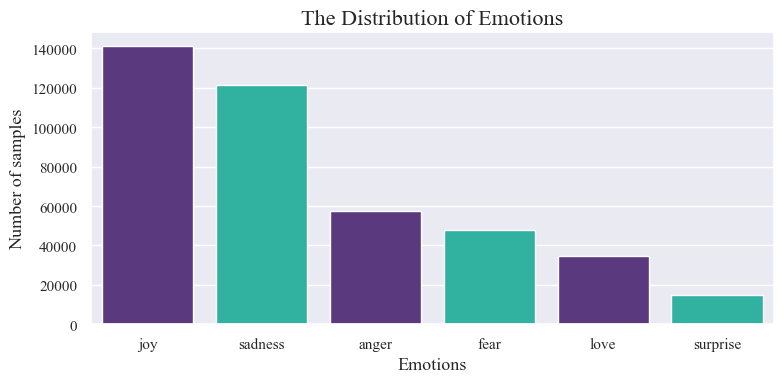

In [30]:
emotion_counts = df["emotion"].value_counts().reset_index()
emotion_counts.columns = ["emotion", "count"]

plt.figure(figsize=(8, 4))
sns.barplot(
    data=emotion_counts,
    x="emotion",
    y="count",
    palette=custom_palette
)

plt.title("The Distribution of Emotions")
plt.xlabel("Emotions")
plt.ylabel("Number of samples")
plt.tight_layout()
plt.show()

Analyzing the number of words per text to assess expressive depth and contextual richness in emotional communication.

Psychological insight:<br>
	•	Short texts dominate → impulsive emotional expression<br>
	•	Long tails → reflective or narrative emotions<br>
	•	Short texts explain annotation disagreement<br>

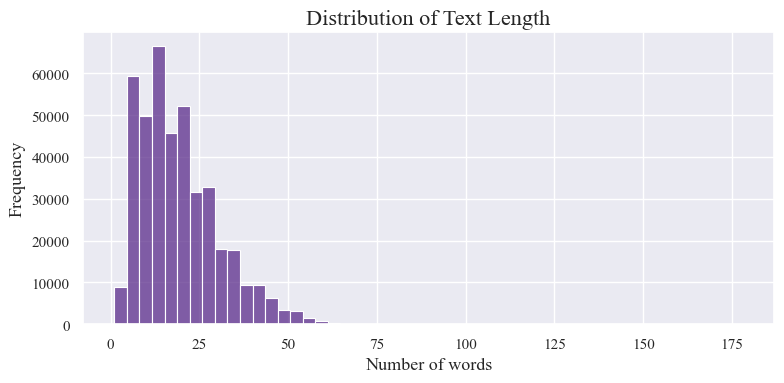

In [31]:
df["text_length_words"] = df["text"].str.split().str.len()

plt.figure(figsize=(8, 4))
sns.histplot(
    df["text_length_words"],
    bins=50,
    color="#5B2D8B"
)

plt.title("Distribution of Text Length")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

Comparison of text length distributions across emotions to examine differences in expressive and cognitive patterns.

/var/folders/cr/f851nq8d2x1760kd65n74rqc0000gn/T/ipykernel_29933/4229086969.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/cr/f851nq8d2x1760kd65n74rqc0000gn/T/ipykernel_29933/4229086969.py:2: UserWarning: 
The palette list has fewer values (2) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(


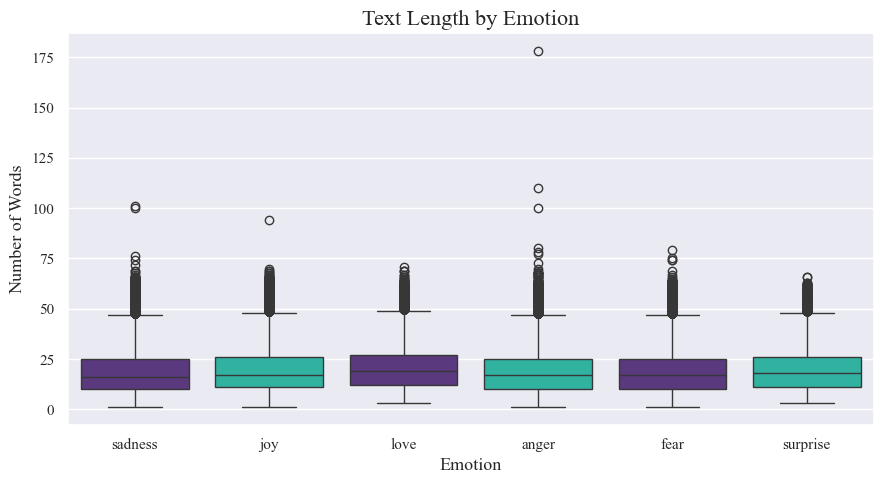

In [32]:
plt.figure(figsize=(9, 5))
sns.boxplot(
    data=df,
    x="emotion",
    y="text_length_words",
    palette=custom_palette
)

plt.title("Text Length by Emotion")
plt.xlabel("Emotion")
plt.ylabel("Number of Words")
plt.tight_layout()
plt.show()

Kernel density estimation highlights overlap between emotional expressions.

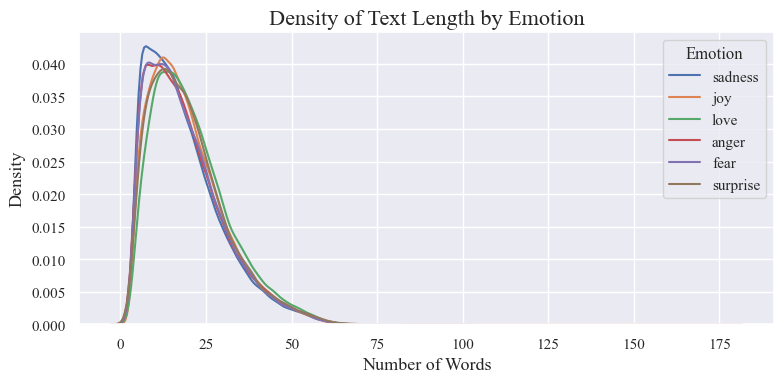

In [34]:
plt.figure(figsize=(8, 4))

for emotion in df["emotion"].unique():
    subset = df[df["emotion"] == emotion]
    sns.kdeplot(
        subset["text_length_words"],
        label=emotion,
        fill=False
    )

plt.title("Density of Text Length by Emotion")
plt.xlabel("Number of Words")
plt.ylabel("Density")
plt.legend(title="Emotion")
plt.tight_layout()
plt.show()

The dataset lacks temporal, user-level, and conversational metadata. Consequently, both human annotators and models infer emotional context from isolated text fragments. This limitation contributes to annotation conflicts and bounds achievable classification performance.

#### Representative Text Samples

We inspect representative, ambiguous, and extreme examples to qualitatively understand emotional expression in the dataset.

In [36]:
# median word length per emotion
lengths_median = df.groupby("emotion")["text_length_words"].median().to_dict()
lengths_median

{'anger': 17.0,
 'fear': 17.0,
 'joy': 17.0,
 'love': 19.0,
 'sadness': 16.0,
 'surprise': 18.0}

In [37]:
def sample_typical_texts(df, emotion, n=3):
    target_len = lengths_median[emotion]
    subset = df[df["emotion"] == emotion].copy()
    subset["distance"] = (subset["text_length_words"] - target_len).abs()
    return subset.sort_values("distance").head(n)[["text", "emotion", "text_length_words"]]

for e in df["emotion"].unique():
    print(f"\n=== Typical Examples for Emotion: {e.upper()} ===")
    display(sample_typical_texts(df, e, n=3))


=== Typical Examples for Emotion: SADNESS ===


,text,emotion,text_length_words
323131,i was at creative therapy and we were talking about my feelings of low self esteem,sadness,16
253997,i feel bad that im excited for this lecture but i feel like i know it,sadness,16
48964,i feel discontent slightly jealous thinking the fact that he may have met some new people,sadness,16



=== Typical Examples for Emotion: JOY ===


,text,emotion,text_length_words
274279,i wouldn t feel this appreciative if i hadn t started on charge away from complete overload,joy,17
96202,i feel that in god s eyes his life and spirit are just as worthwhile as mine,joy,17
289811,when i came across an old friend whom i had not seen for a very long time,joy,17



=== Typical Examples for Emotion: LOVE ===


,text,emotion,text_length_words
288617,i feel like it is the job of anyone who says they are my friend to be unhumanly loyal,love,19
241347,i feel thank you so much for being gracious enough to allow me to share this here suzy hugs,love,19
361393,i feel like the calvin harris florence the machine song sweet nothing again in case i blogged it already,love,19



=== Typical Examples for Emotion: ANGER ===


,text,emotion,text_length_words
223381,i feel like the people around me feels wronged and that it is me who hurt them,anger,17
99529,i was extremely excited to be graduating but at the same time the feeling was bitter sweet,anger,17
306261,i still feel pissed about not hitting my weight mark last february i was so freaking close,anger,17



=== Typical Examples for Emotion: FEAR ===


,text,emotion,text_length_words
63988,i would feel nervous about trying it in anything bigger than a van or pickup based camper,fear,17
246340,i can feel people watching me all the time and i m scared that he s here,fear,17
28693,i come here though it feels strange like going in a room youve not visited in years,fear,17



=== Typical Examples for Emotion: SURPRISE ===


,text,emotion,text_length_words
392428,i tell him im grateful for every mile but feel weird with it not being on the way,surprise,18
393005,i determine that i deserve to be put aside and i feel terribly surprised when i am not,surprise,18
284277,i was depressed and disinclined for sight seeing and did not go feeling are array curious and interesting,surprise,18


#### Ambiguous Texts (Very Short Length)

We inspect very short texts, which often lack sufficient context and are more prone to annotation disagreement.

In [38]:
short_threshold = 3 #(words)
short_texts = df[df["text_length_words"] <= short_threshold]

short_texts.sample(15)[["text", "emotion", "text_length_words"]]

,text,emotion,text_length_words
54803,im feeling super,joy,3
381839,im feeling dull,sadness,3
241228,im feeling bashful,fear,3
159332,my first kiss,joy,3
389861,im feeling envious,anger,3
123634,i feel romantic,love,3
34486,im feeling slutty,love,3
123797,im feeling humiliated,sadness,3
304804,im feel insecure,fear,3
90016,im feeling anxious,fear,3


#### Extreme Text Lengths (Narrative Outliers)

We inspect unusually long texts, which may encode multiple emotional states but are constrained to a single label.

In [39]:
df.sort_values("text_length_words", ascending=False).head(15)[["text", "emotion", "text_length_words"]]

,text,emotion,text_length_words
369479,a few days back i was waiting for the bus at the bus stop before getting into the bus i had prepared the exact amoun...,anger,178
206503,two years back someone invited me to be the tutor of her granddaughter the granddaughter asked me some questions in ...,anger,110
103972,i have been thinking of changing my major for a few months my original major was chinese language and it blocks my w...,sadness,101
356012,my living and working conditions at home were unbearable we used to live in a three room flat together with two more...,sadness,100
251113,when i got into a bus i found that my wallet had been stolen it was not a great loss from the monetary point of view...,anger,100
154966,i had a dream i had a very close friend who had several stone houses in the new territories villages but they did no...,joy,94
124400,i worked with several classmates on a project i was very anxious about the project while my partners showed no conce...,anger,80
284047,i was camping in an old broken hut which had no lights i had brought along a lamp which was not working very well th...,fear,79
312637,last semester when i dated a girl whom ive known for almost a year however one night she said she wanted us to be ju...,anger,78
219441,i was a prefect at secondary school on the sports day i told others that i would take down the names of the people w...,anger,77


#### Conflicting Annotations — Qualitative Inspection

We inspect texts that received multiple emotion labels to understand sources of human disagreement.

In [40]:
conflict_texts = label_conflicts[label_conflicts > 1].index
df[df["text"].isin(conflict_texts)].sort_values("text").head(20)

,text,emotion,label,text_length_words
247324,as a child,anger,0,3
202953,as a child,fear,1,3
247824,at school,fear,1,2
66688,at school,anger,0,2
99131,doesnt apply,anger,0,2
293913,doesnt apply,fear,1,2
336901,during the christmas holidays,joy,2,4
198779,during the christmas holidays,sadness,4,4
49707,i abhor lies of simple denial or baseless accusations i feel admiration for lies that weave in upon themselves self ...,love,3,35
15393,i abhor lies of simple denial or baseless accusations i feel admiration for lies that weave in upon themselves self ...,joy,2,35


## Qualitative Findings from Representative Text Samples

The qualitative inspection of representative, ambiguous, and extreme text samples reveals that emotional expression in this dataset is fundamentally human, contextual, and often ambiguous. This behavior is not a flaw of the dataset, but an inherent property of natural language and affective communication.

### Conflicting Annotations and Human Subjectivity

Texts that received multiple emotion labels are typically short, underspecified phrases (e.g., “as a child”, “at school”, “during the christmas holidays”) or emotionally evocative statements lacking explicit context. These utterances act as memory or context anchors rather than direct emotional expressions. As a result, annotators infer emotion based on personal experience, cultural background, and assumed narrative context.

This observation highlights that emotion is not always encoded directly in the text, but emerges from the interaction between language and the reader’s internal representation. Consequently, annotation disagreement reflects genuine human subjectivity rather than labeling error.

### Very Short Texts and Lexical Emotion Expression

Very short texts (typically three words or fewer) often contain explicit emotional keywords (e.g., “i feel anxious”, “i feel romantic”). These samples rely almost entirely on lexical cues rather than semantic or narrative context. While such texts are easy for both humans and models to classify, they represent a simplified form of emotional expression and may inflate performance metrics during model evaluation.

### Long Texts and Narrative Emotional Trajectories

Extremely long texts frequently contain emotional trajectories, transitions, and mixed affective states (e.g., anxiety evolving into anger, or sadness intertwined with relief). Despite this complexity, each sample is constrained to a single emotion label. This structural limitation forces annotators to select a dominant or salient emotion, effectively collapsing a multi-dimensional emotional experience into a single class.

This observation suggests that single-label emotion classification captures a simplified snapshot of emotional framing rather than the full affective dynamics present in narrative text.

### Typical-Length Texts as the Emotional Core of the Dataset

Texts with lengths near the median exhibit the most coherent and interpretable emotional expression. These samples typically provide sufficient context while maintaining a consistent emotional tone, making them the strongest contributors to model learning. They form the emotional “core” of the dataset and anchor the overall classification task.

### Implications for Modeling and Evaluation

The qualitative analysis demonstrates that the dataset contains multiple regimes of emotional expression: lexical (short), contextual (medium), and narrative (long). A single classification model is therefore expected to encounter inherent ambiguity, particularly between semantically adjacent emotions such as joy and love or anger and fear. These findings imply that perfect classification performance is neither realistic nor scientifically meaningful, and that evaluation metrics must be interpreted in light of human subjectivity and contextual uncertainty.

__________

## Dataset Definition for Modeling

### Modeling Dataset Policy (Retention vs. Removal)

No aggressive removal of duplicates or conflicting annotations is performed at this stage. This decision is intentional and is justified by both methodological and scientific considerations.

**Exact duplicates** provide limited informational value but are not immediately removed in the EDA phase, since the current objective is exploratory analysis and characterization of dataset properties. Removal can be performed later as a controlled modeling experiment (e.g., baseline vs. de-duplicated training), ensuring that any performance changes are attributable to the cleaning decision.

**Duplicate texts with identical labels** reflect repeated phrasing patterns in real communication and may represent frequency effects present in natural language. Retaining these samples preserves the dataset’s empirical distribution and avoids introducing subjective filtering decisions during the analysis stage.

**Conflicting labels for identical texts** are interpreted as an intrinsic outcome of human subjectivity and context inference in emotion annotation, particularly for short or underspecified texts. Removing all conflicting cases would artificially simplify the task and may produce overly optimistic evaluation results. Therefore, conflicting samples are retained during analysis and treated as a realistic source of uncertainty, with explicit documentation of their presence and potential impact on model performance.

Cleaning actions (e.g., dropping exact duplicates or isolating conflicting cases) are deferred to the modeling phase and implemented as explicitly reported experimental variants to preserve transparency and reproducibility.

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
X = df["text"]
y = df["label"]

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=42
)

print("Train:", X_train.shape, y_train.shape)
print("Val  :", X_val.shape, y_val.shape)
print("Test :", X_test.shape, y_test.shape)

Train: (291766,) (291766,)
Val  : (62521,) (62521,)
Test : (62522,) (62522,)


In [43]:
# verifying - quality check
def show_split_distribution(y_split, split_name):
    dist = y_split.value_counts(normalize=True).sort_index()
    print(f"\n{split_name} label distribution:")
    print(dist)

show_split_distribution(y_train, "Train")
show_split_distribution(y_val, "Validation")
show_split_distribution(y_test, "Test")


Train label distribution:
label
0    0.137514
1    0.114468
2    0.338446
3    0.082902
4    0.290750
5    0.035919
Name: proportion, dtype: float64

Validation label distribution:
label
0    0.137506
1    0.114474
2    0.338446
3    0.082900
4    0.290750
5    0.035924
Name: proportion, dtype: float64

Test label distribution:
label
0    0.137520
1    0.114472
2    0.338441
3    0.082899
4    0.290746
5    0.035923
Name: proportion, dtype: float64


In [44]:
from pathlib import Path

In [45]:
out_dir = Path("../data/processed")
out_dir.mkdir(parents=True, exist_ok=True)

train_df = pd.DataFrame({"text": X_train.values, "label": y_train.values})
val_df   = pd.DataFrame({"text": X_val.values,   "label": y_val.values})
test_df  = pd.DataFrame({"text": X_test.values,  "label": y_test.values})

train_path = out_dir / "train.csv"
val_path   = out_dir / "val.csv"
test_path  = out_dir / "test.csv"

train_df.to_csv(train_path, index=False, encoding="utf-8")
val_df.to_csv(val_path, index=False, encoding="utf-8")
test_df.to_csv(test_path, index=False, encoding="utf-8")

print("Saved:", train_path)
print("Saved:", val_path)
print("Saved:", test_path)

Saved: ../data/processed/train.csv
Saved: ../data/processed/val.csv
Saved: ../data/processed/test.csv


In [46]:
split_summary = pd.DataFrame({
    "split": ["train", "val", "test"],
    "rows": [len(train_df), len(val_df), len(test_df)]
})
split_summary

,split,rows
0,train,291766
1,val,62521
2,test,62522
